# Manta Fingerprint Identification with Principal Computer Vision Algorithms

I've been searching for a project to do on pattern matching with computer vision fundamentals for a while. I threw around some ideas in my head like detecting different machine bolts, nuts, and screws to categories them, or detecting and identifying playing cards, or looking at human fingerprint detection. As usual, I had to turn to the ocean for inspiration.

As I was doing a night scuba dive with manta rays with a friend of mine, I couldn't help myself to think about how cool it would be to identify manta rays by their unique patterns. I noticed that on the bottom of a manta ray exists, what appears to be, a unique set of black splatters. If I could apply the same principles of human fingerprint identification to manta rays, perhaps I could uniquely identify the individual!

Turns out, I was definetely onto something. Manta rays do indeed have a unique pattern on their underside that scientists have used to identify individuals. In fact, the original researchers of this created an organization called [Manta Matcher](https://mantamatcher.org/) that has compiled a database of **12,658** different animals from around the world!

The original research paper [Manta Matcher: automated photographic identification of manta rays using keypoint features](https://pubmed.ncbi.nlm.nih.gov/23919138/) provides a very comprehensive overview of the algorithm they implemented using a combination of basic computer vision algorithms. Since this paper was published in 2013, much of the modern deep learning techniques that have been developed weren't avaliable at the time. So, pulling techniques descriped in the paper, I will reimplement their technique and see if I can automate some of the steps they took to identify manta rays.

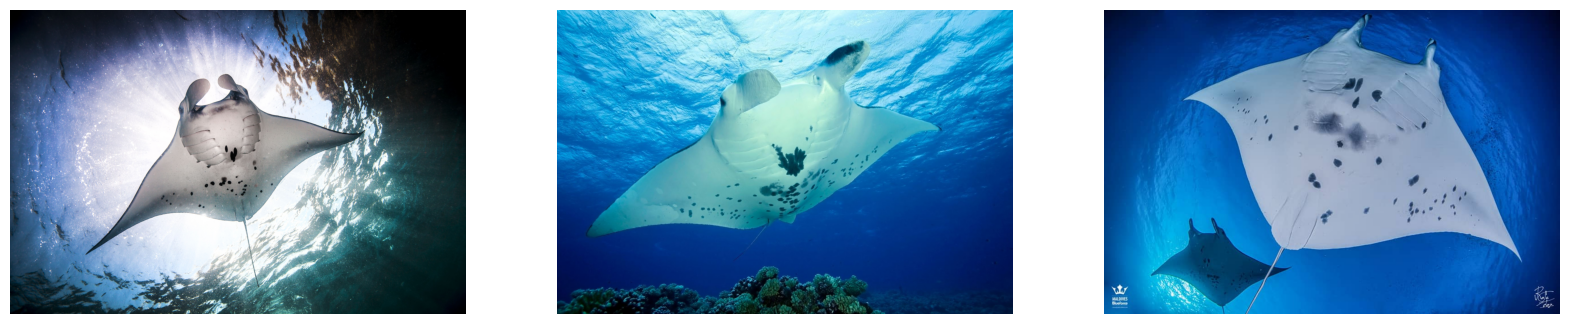

In [3]:
import matplotlib.pyplot as plt
import cv2

frame_1 = cv2.imread('manta_1.jpg')
frame_2 = cv2.imread('manta_2.jpg')
frame_3 = cv2.imread('manta_3.jpg')

fig, ax = plt.subplots(1, 3, figsize=(20, 8))

ax[0].imshow(cv2.cvtColor(frame_1, cv2.COLOR_BGR2RGB))
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(frame_2, cv2.COLOR_BGR2RGB))
ax[1].axis('off')
ax[2].imshow(cv2.cvtColor(frame_3, cv2.COLOR_BGR2RGB))
ax[2].axis('off')

plt.show()

## The Plan

The original paper lays out the algorithm very simply:

- Manually align the orientation of the manta ray in the image to a standard.

- Manually select a region of interest (ROI) around the manta ray's belly.

- Enchance the image by applying noise removal and adaptive contrast equalization.

- Identify unique features from the spotted patterns on the manta ray's belly.

- Match the features to a database of known manta rays.

Obviously, since the first two are manual steps, this is where we might apply some automation. The rest are still very applicable principal computer vision algorithms, even in the world of AI and deep learning.

For the first step, we can automate this in a series of two steps. First, we can identify the manta in the image using an **object detection** model. If we can identify the manta, we can then run a **pose estimation** model to capture the orientation of the manta. This will allow us to do two things: 1) rotate the image to a standard orientation, and 2) crop the image to the region of interest.

Now, in this notebook, I won't be able to collect a large enough dataset for the object detection or pose estimation models (not until I collect enough data). Instead, we can manually annotate the above 3 images and use them as a test to implement the rest of the algorithm.

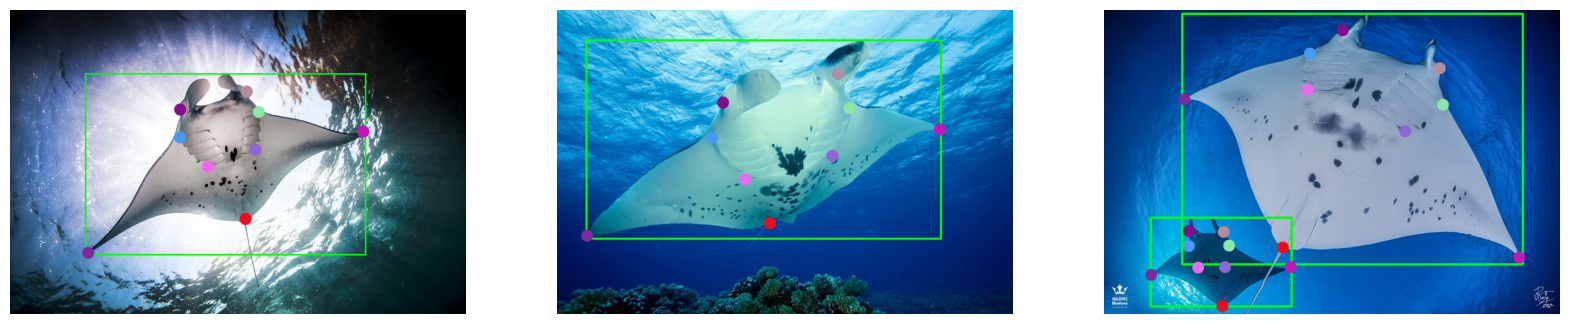

In [90]:
import json
import numpy as np

mantas = []

keypoints_coco = json.load(open('keypoints_coco.json'))
instances_coco = json.load(open('instances_coco.json'))

keypoint_colors = [(np.random.rand(3) * 255).astype(int) for _ in range(9)]

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for image, ax in zip(instances_coco['images'], axes):
    frame = cv2.imread(image['file_name'])
    
    image_size = (image['width'], image['height'])
    line_width = int(min(image_size) * 0.005)
    circle_radius = int(min(image_size) * 0.02)

    instance_annos = [a for a in instances_coco['annotations'] if a['image_id'] == image['id']]
    keypoint_annos = [a for a in keypoints_coco['annotations'] if a['image_id'] == image['id']]
    
    for index, (instance, keypoints) in enumerate(zip(instance_annos, keypoint_annos)):
        
        manta = {
            'image': image['file_name'],
            'box': instance['bbox'],
            'keypoints': np.array(keypoints['keypoints']).reshape(-1, 3)[:, :2]
        }
        
        mantas.append(manta)
        
        x, y, w, h = manta['box']
        cv2.rectangle(frame, (int(x), int(y)), (int(x+w), int(y+h)), (0, 255, 0), line_width)
        
        c = 0
        for i in range(len(manta['keypoints'])):
            x, y =  manta['keypoints'][i]
            color = keypoint_colors[c]
            cv2.circle(frame, (int(x), int(y)), circle_radius, color.tolist(), -1)
            c += 1
    
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.show()

Using object detection provides a few benefits in the context of this implements.

- For the sake of computational efficiency, we only want to run the pose estimation if we have a high confidence that a manta ray exists in the image. In combination with certain brightness filters, we can greatly increase efficiency.

- We can use the bounding box of the object detection to crop the image to a certain region of interest. This will allow us to focus more on an individual manta ray, while also reducing the size of the image needed to be processed. In marine environments, studying animals that are social and congregate in groups often results in multiple animals captured in the same image. This can increase the possibility of false positives in the pose estimation and the unique fingerprint identification from one animal to another.

Using the object detection as a filter, we can then process the pose estimation model. And this model provides us again with several benefits.

- We now know the standard orientation of the manta ray. We can now rotate the animal in the frame to a standard: head facing to the top of the image with the rear facing to the bottom.

- In this particular animal, we have selected 9 keypoints: the 2 eyes, the outside point of the top gill flaps, the outside points of the bottom gill flaps, the tips of the pectoral fins, and the base of the tail or bottom of the pelvic fins. Generally speaking, we don't need all of these keypoints to determine the unique fingerprint, or even the orientation of the animal. We could rely on a subset. But this adds an additional layer of robustness serving, again, several purposes. 1) We can use the gill keypoints with the tail keypoint to crop a region (similar to the region in the original paper) around the belly of the manta ray. 2) With all of this keypoints, we can be more confident that we have captured a manta ray that is only translated or rotated in the 2D plane and not in the 3D plane. The biomarkers will not match nearly as well if the manta ray is rotated in the 3D plane. And finally, 3) we can help identify the manta ray even more if we know the sex of the animal. The pelvic fins look distinctly different depending on the sex.

Okay, with all that background, we can work on reimplementation. Let's start with orientation alignment for the manta.

In [91]:
# orientate keypoints to be relative to the bounding box
# Since we are going to crop out the rest of the image
for manta in mantas:
    x, y, w, h = manta['box']
    keypoints = manta['keypoints']
    for i in range(len(keypoints)):
        keypoints[i][0] -= x
        keypoints[i][1] -= y

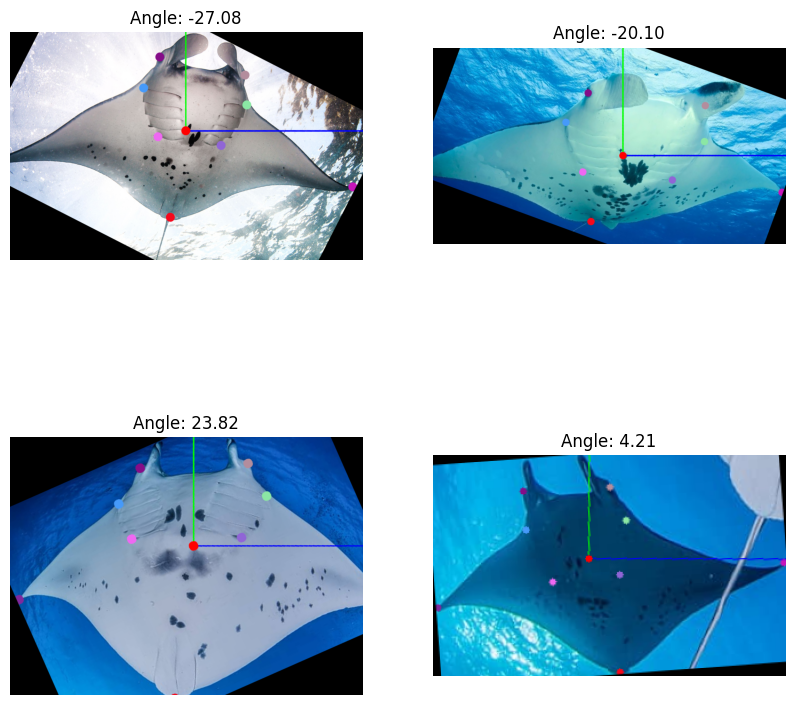

In [101]:
def get_body_part(part, keypoints):
    mapp = {"eye_1": 0, "eye_2": 1, "gill_1": 2, "gill_2": 3, "gill_3": 4, "gill_4": 5, "pectoral_1": 6, "pectoral_2": 7, "pelvic": 8}
    return keypoints[mapp[part]]


def manta_orientation(manta):
    # use all the keypoints to compute the orientation
    points = manta['keypoints']
    
    # PCA is used to compute the orientation of the points
    # https://docs.opencv.org/4.x/d1/dee/tutorial_introduction_to_pca.html
    mean, eigen_vec, eigen_val = cv2.PCACompute2(points, np.array([]))
    
    center = (int(mean[0, 0]), int(mean[0, 1]))
    axis_1 = (center[0] + eigen_vec[0, 0] * eigen_val[0, 0], center[1] + eigen_vec[0, 1] * eigen_val[0, 0])
    axis_2 = (center[0] - eigen_vec[1, 0] * eigen_val[1, 0], center[1] - eigen_vec[1, 1] * eigen_val[1, 0])
    
    angle = np.arctan2(eigen_vec[0, 1], eigen_vec[0, 0])
    
    return center, angle, axis_1, axis_2


fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for manta, ax in zip(mantas, axes.flatten()):
    frame = cv2.imread(manta['image'])
    
    # crop the frame to the bounding box of the manta
    x, y, w, h = manta['box']
    frame = frame[int(y):int(y+h), int(x):int(x+w)]
    
    manta['orientation'] = manta_orientation(manta)

    center, angle, axis_1, axis_2 = manta['orientation']
    
    image_size = (frame.shape[1], frame.shape[0])
    line_width = max(int(min(image_size) * 0.005), 1)
    circle_radius = max(int(min(image_size) * 0.02), 1)

    cv2.line(frame, center, (int(axis_1[0]), int(axis_1[1])), (255, 0, 0), line_width)
    cv2.line(frame, center, (int(axis_2[0]), int(axis_2[1])), (0, 255, 0), line_width)
    cv2.circle(frame, center, circle_radius, (0, 0, 255), -1)
    
    angle = np.rad2deg(angle)
    
    manta["angle"] = angle
    
    for i in range(len(manta['keypoints'])):
        x, y =  manta['keypoints'][i]
        color = keypoint_colors[i]
        cv2.circle(frame, (int(x), int(y)), circle_radius, color.tolist(), -1)
    
    rows, cols, _ = frame.shape
    frame_matrix = cv2.getRotationMatrix2D(center, angle, 1)
    frame = cv2.warpAffine(frame, frame_matrix, (cols, rows))
    
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax.set_title('Angle: {:.2f}'.format(angle))
    ax.axis('off')
    
plt.show()

Wow! Alright a lot of information to digest. Let's break it down.

First, given the keypoints detected, we assume that there is are geometric properties natural to the skeleton of the manta ray such that we can orient the manta ray in a standard direction. We assume that spatially the manta ray is longer than it is wide. This will give us two axes one which will be from the head to the tail. The other, from left to right. As long as we select the right axis, we can then rotate the image where the head is towards the top of the image.

This method is not completely perfect as 3D rotations are still present which orientate the skeleton in a different direction. But with the sample images, we see that the <b style="color: green">green</b> axis pierces the head in every one. The bottom-left image is nearly perfect as it is probably the best captured image of the 2d representation of the underside.

To find this special geometric axis of the manta, we use the keypoints provided by the pose estimation model and calculate the "axis of least second moment" or "axis of least inertia". This axis will pass through the moment of inertia (in physics terms the center of mass). A lot of linear algebra and calculus is involved in this calculation. A very good explanation can be found here [Geometric Properties | Binary Images](https://www.youtube.com/watch?v=ZPQiKXqHYrM).

Computationally, we use PCA (Principal Component Analysis) to calculate the eigenvectors of the matrix of keypoints. If you are familar with PCA, you know that it is a method of reducing dimensionality of a dataset such that the variance of the dataset is maximized. In a machine learning regression context, we use this to filter out features that are not important. In this context, we want to know the overall direction of the keypoints. OpenCV provides a comprehensive tutorial on this [Introduction to Principal Component Analysis (PCA)](https://docs.opencv.org/4.x/d1/dee/tutorial_introduction_to_pca.html) for which I pulled reference code from.

Now, admittedly, this isn't the most robust solution. We could implement a more complex algorithm that actually segments the entire manta ray and then calculates this property. Given how much the body of the manta ray bends and twists, this method will given variable centers of mass throwing the axis off. We make an assumption here that the pose estimation model is trained on a dataset of well taken images where the manta ray underside is mostly parallel to the image plane.